### Data List

In [1]:
import os
from os import listdir
from os.path import isfile, join
import ntpath

data_dir = 'dataset_cc/'

data_files = []

data_files = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) if '.npz' in f]
print(len(data_files))

data_files.sort()


35


### Hyperparameters Setting

In [2]:
'''
Interval
'''
# Divide 1second by 200 equally
IntervalDim = 200

'''
Velocity
'''
# Divide Midi velocity values[0, 127] by 32
VelocityDim = 32
VelocityOffset = IntervalDim

'''
Note On/Off
'''
# Note values [0, 127]
NoteOnDim = NoteOffDim = 128
NoteOnOffset = IntervalDim + VelocityDim
NoteOffOffset = IntervalDim + VelocityDim + NoteOnDim

'''
CC On/Off
'''
# CC = sustain pedal on/off
CCDim = 2
CCOffset = IntervalDim + VelocityDim + NoteOnDim + NoteOffDim

'''
Total Event Dim
'''
EventDim = IntervalDim + VelocityDim + NoteOnDim + NoteOffDim + CCDim # 390

'''
Other Hyperparameters
'''
# Attention Range
Time = 2000
# Event Embedding Dimension
EmbeddingDim = 512 

# Multi-head Attention Related
HeadDim = 32 
Heads = 16
ContextDim = HeadDim * Heads


### Load data from npz and converter to token sequence

x shape :  (2000,)
y shape :  (2000,)


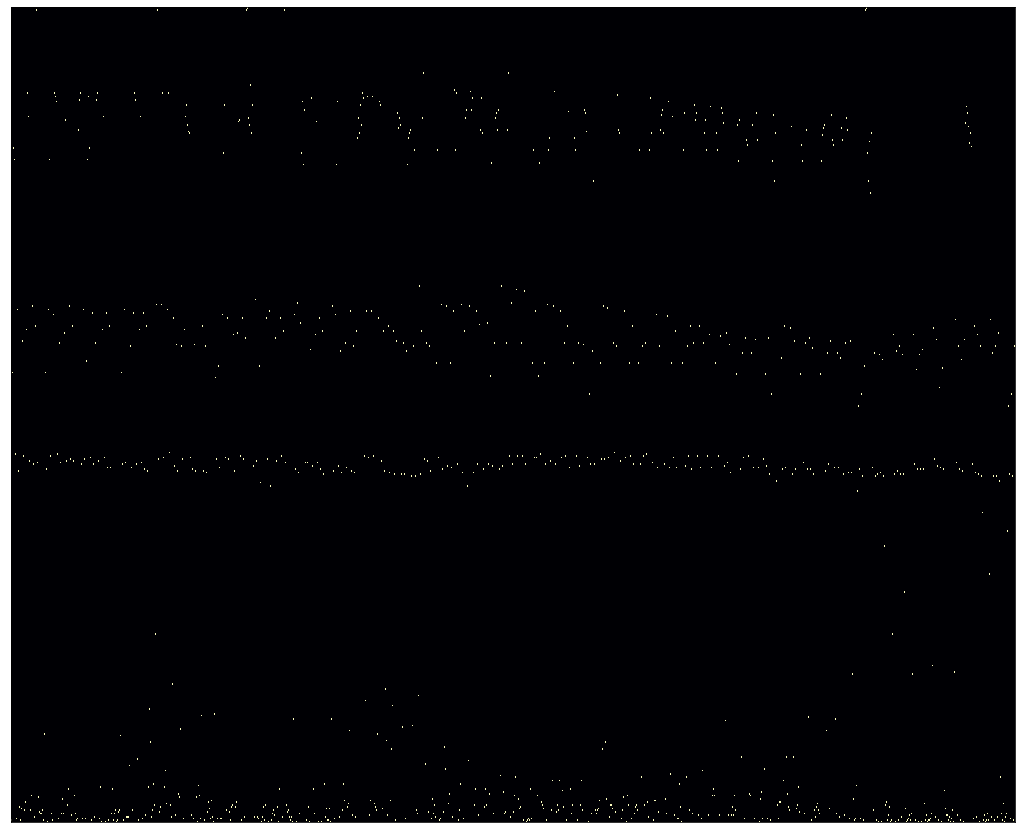

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

def get_data(length=Time):
    # load data randomly
    index = np.random.randint(0, len(data_files))
    data = np.load(data_files[index])['eventlist']
    
    # time augmentation
    data[:, 0] *= np.random.uniform(0.95, 1.05)
    
    # absolute time to relative interval
    data[1:, 0] = data[1:, 0] - data[:-1, 0]
    data[0, 0] = 0
    
    # discretize interval into IntervalDim
    data[:, 0] = np.clip(np.round(data[:, 0] * IntervalDim), 0, IntervalDim - 1)
    
    # Note augmentation
    data[:, 2] += np.random.randint(-6, 6)
    data[:, 2] = np.clip(data[:, 2], 0, NoteOnDim)
    
    eventlist = []
    for d in data:
        # append interval
        interval = d[0]
        eventlist.append(interval)
    
        # note on case
        if d[1] == 1:
            velocity = (d[3] / 128) * VelocityDim + VelocityOffset
            note = d[2] + NoteOnOffset
            eventlist.append(velocity)
            eventlist.append(note)
            
        # note off case
        elif d[1] == 0:
            note = d[2] + NoteOffOffset
            eventlist.append(note)
        # CC
        elif d[1] == 2:
            event = CCOffset + d[3]
            eventlist.append(event)
            
    eventlist = np.array(eventlist).astype(np.int)
    
    if len(eventlist) > (length+1):
        start_index = np.random.randint(0, len(eventlist) - (length+1))
        eventlist = eventlist[start_index:start_index+(length+1)]
        
    # pad zeros
    if len(eventlist) < (length+1):
        pad = (length+1) - len(eventlist)
        eventlist = np.pad(eventlist, (pad, 0), 'constant')
        
    x = eventlist[:length]
    y = eventlist[1:length+1]
    
    return x, y
    
x, y = get_data()
print('x shape : ', x.shape)
print('y shape : ', y.shape)
# print(x)
# print(y)
    
'''
Visualization
'''
roll = np.zeros([len(x), EventDim])
for t, _x in enumerate(x):
    roll[t, _x] = 1

plt.figure(figsize=[18, 15])
librosa.display.specshow(roll.T)
plt.show()

### GPT-2 Source referenced from https://github.com/openai/gpt-2/blob/master/src/model.py

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.training import HParams

def default_hparams():
    return HParams(
        n_vocab=EventDim,
        n_ctx=1024,
        n_embd=768,
        n_head=12,
        n_layer=6,
        n_time=Time,
    )

def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def softmax(x, axis=-1):
    x = x - tf.reduce_max(x, axis=axis, keepdims=True)
    ex = tf.exp(x)
    return ex / tf.reduce_sum(ex, axis=axis, keepdims=True)

def gelu(x):
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

def norm(x, scope, *, axis=-1, epsilon=1e-5):
    """Normalize to mean = 0, std = 1, then do a diagonal affine transform."""
    with tf.variable_scope(scope):
        n_state = x.shape[-1].value
        g = tf.get_variable('g', [n_state], initializer=tf.constant_initializer(1))
        b = tf.get_variable('b', [n_state], initializer=tf.constant_initializer(0))
        u = tf.reduce_mean(x, axis=axis, keepdims=True)
        s = tf.reduce_mean(tf.square(x-u), axis=axis, keepdims=True)
        x = (x - u) * tf.rsqrt(s + epsilon)
        x = x*g + b
        return x

def split_states(x, n):
    """Reshape the last dimension of x into [n, x.shape[-1]/n]."""
    *start, m = shape_list(x)
    return tf.reshape(x, start + [n, m//n])

def merge_states(x):
    """Smash the last two dimensions of x into a single dimension."""
    *start, a, b = shape_list(x)
    return tf.reshape(x, start + [a*b])

def conv1d(x, scope, nf, *, w_init_stdev=0.02):
    with tf.variable_scope(scope):
        *start, nx = shape_list(x)
        w = tf.get_variable('w', [1, nx, nf], initializer=tf.random_normal_initializer(stddev=w_init_stdev))
        b = tf.get_variable('b', [nf], initializer=tf.constant_initializer(0))
        c = tf.reshape(tf.matmul(tf.reshape(x, [-1, nx]), tf.reshape(w, [-1, nf]))+b, start+[nf])
        return c

def attention_mask(nd, ns, *, dtype):
    """1's in the lower triangle, counting from the lower right corner.
    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)


def attn(x, scope, n_state, *, hparams):
    assert x.shape.ndims == 3  # Should be [batch, sequence, features]
    assert n_state % hparams.n_head == 0

    def split_heads(x):
        # From [batch, sequence, features] to [batch, heads, sequence, features]
        return tf.transpose(split_states(x, hparams.n_head), [0, 2, 1, 3])

    def merge_heads(x):
        # Reverse of split_heads
        return merge_states(tf.transpose(x, [0, 2, 1, 3]))

    def mask_attn_weights(w):
        # w has shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst.
        _, _, nd, ns = shape_list(w)
        b = attention_mask(nd, ns, dtype=w.dtype)
        b = tf.reshape(b, [1, 1, nd, ns])
        w = w*b - tf.cast(1e10, w.dtype)*(1-b)
        return w
    
    def relative_attn(q):
        # q have shape [batch, heads, sequence, features]
        batch, heads, sequence, features = shape_list(q)
        E = tf.get_variable('E', [heads, sequence, features])
        # [heads, batch, sequence, features]
        q_ = tf.transpose(q, [1, 0, 2, 3])
        # [heads, batch * sequence, features]
        q_ = tf.reshape(q_, [heads, batch * sequence, features])
        # [heads, batch * sequence, sequence]
        rel = tf.matmul(q_, E, transpose_b=True)
        # [heads, batch, sequence, sequence]
        rel = tf.reshape(rel, [heads, batch, sequence, sequence])
        # [heads, batch, sequence, 1+sequence]
        rel = tf.pad(rel, ((0, 0), (0, 0), (0, 0), (1, 0)))
        # [heads, batch, sequence+1, sequence]
        rel = tf.reshape(rel, (heads, batch, sequence+1, sequence))
        # [heads, batch, sequence, sequence]
        rel = rel[:, :, 1:]
        # [batch, heads, sequence, sequence]
        rel = tf.transpose(rel, [1, 0, 2, 3])
        return rel
        
    def multihead_attn(q, k, v):
        # q, k, v have shape [batch, heads, sequence, features]
        w = tf.matmul(q, k, transpose_b=True)
        w = w + relative_attn(q)
        w = w * tf.rsqrt(tf.cast(v.shape[-1].value, w.dtype))

        w = mask_attn_weights(w)
        w = softmax(w)
        a = tf.matmul(w, v)
        return a

    with tf.variable_scope(scope):
        c = conv1d(x, 'c_attn', n_state*3)
        q, k, v = map(split_heads, tf.split(c, 3, axis=2))
        present = tf.stack([k, v], axis=1)

        a = multihead_attn(q, k, v)
        a = merge_heads(a)
        a = conv1d(a, 'c_proj', n_state)
        return a, present


def mlp(x, scope, n_state, *, hparams):
    with tf.variable_scope(scope):
        nx = x.shape[-1].value
        h = gelu(conv1d(x, 'c_fc', n_state))
        h2 = conv1d(h, 'c_proj', nx)
        return h2


def block(x, scope, *, hparams):
    with tf.variable_scope(scope):
        nx = x.shape[-1].value
        a, present = attn(norm(x, 'ln_1'), 'attn', nx, hparams=hparams)
        x = x + a
        m = mlp(norm(x, 'ln_2'), 'mlp', nx*4, hparams=hparams)
        x = x + m
        return x, present

def expand_tile(value, size):
    """Add a new axis of given size."""
    value = tf.convert_to_tensor(value, name='value')
    ndims = value.shape.ndims
    return tf.tile(tf.expand_dims(value, axis=0), [size] + [1]*ndims)

def model(hparams, X, scope='model', reuse=False):
    with tf.variable_scope(scope, reuse=reuse):
        results = {}
        batch, sequence = shape_list(X)

        wte = tf.get_variable('wte', [hparams.n_vocab, hparams.n_embd],
                             initializer=tf.random_normal_initializer(stddev=0.02))
        h = tf.gather(wte, X)

        # Transformer
        presents = []
        for layer in range(hparams.n_layer):
            h, present = block(h, 'h%d' % layer, hparams=hparams)
            presents.append(present)
        results['present'] = tf.stack(presents, axis=1)
        h = norm(h, 'ln_f')

        # Language model loss.  Do tokens <n predict token n?
        h_flat = tf.reshape(h, [batch*sequence, hparams.n_embd])
        logits = tf.matmul(h_flat, wte, transpose_b=True)
        logits = tf.reshape(logits, [batch, sequence, hparams.n_vocab])
        results['logits'] = logits
        return results

### Main Graph Draw

In [12]:
hparams = default_hparams()
print(hparams)


tf.reset_default_graph()

X = tf.placeholder(tf.int32, [None, hparams.n_time])
Y = tf.placeholder(tf.int32, [None, hparams.n_time])

X_onehot = tf.one_hot(X, axis=2, depth=hparams.n_vocab)

logits = model(hparams, X)['logits']
probs = tf.nn.softmax(logits, axis=2)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=logits)
loss = tf.reduce_mean(cross_entropy)

#temperature = tf.Variable(1., name='temperature')
temperature = 0
u = tf.random.uniform(shape=tf.shape(logits[:, -1]), minval=1e-5, maxval=1.-1e-5)
u = (logits[:, -1] - tf.log(temperature + 1e-8)) - tf.log(-tf.log(u))
sample = tf.argmax(u, axis=1)

#dist = tf.distributions.Categorical(logits=logits[:, -1])
#sample = dist.sample()

'''
Train
'''
global_step = tf.Variable(0, name='global_step')
learning_rate = tf.Variable(1e-3, name='learning_rate')
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step)

'''
Session Open
'''

sess_config = tf.ConfigProto()
# GPU number to use

gpu_options = tf.GPUOptions(visible_device_list= '1')
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

print('graph create')

[('n_ctx', 1024), ('n_embd', 768), ('n_head', 12), ('n_layer', 6), ('n_time', 2000), ('n_vocab', 490)]
graph create


### Load model if exist

In [7]:
import tensorflow.contrib.slim as slim
from tensorflow.python import pywrap_tensorflow

load_dir = 'save/gpt2-cc-interval200-attention1000'
save_dir = 'save/gpt2-cc-interval200-attention1000'

def get_variables_from_checkpoint_file(file_name):
    variables = []
    reader = pywrap_tensorflow.NewCheckpointReader(file_name)

    var_to_shape_map = reader.get_variable_to_shape_map()
    for key in sorted(var_to_shape_map):
        variables.append((key, var_to_shape_map[key]))

    return variables

saver = tf.train.Saver()

# set True to load model
if False:
    restore_file = tf.train.latest_checkpoint(load_dir)
    if restore_file is not None:
        try:
            saver.restore(sess, restore_file)
            print("Model restored.")
            
        # Partial weight load
        except: 
            saved_variables = get_variables_from_checkpoint_file(restore_file)
            model_variables = slim.get_variables_to_restore()
            restore_variables = []
            for model_variable in model_variables:
                for saved_variable_name, saved_variable_shape in saved_variables:
                    model_variable_name = model_variable.name.split(":")[0]
                    if saved_variable_name == model_variable_name and tuple(saved_variable_shape) == model_variable.shape:
                        restore_variables.append(model_variable)

            init_saver = tf.train.Saver(restore_variables)
            init_saver.restore(sess, restore_file)
            print("Model partially restored.")
    else:
        print('model not exist.')
        

### Logger

In [8]:
from tensorboardX import SummaryWriter

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)

    def log(self, log_string, value, iteration):
            self.add_scalar(log_string, value, iteration)
            
logger = Logger(save_dir)            


### Train Loop

In [9]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import librosa.display
from time import sleep
import time

batch_size = 1

while(True):
    #sleep(5)
    for _ in range(100):
        _inputs = []
        _targets = []
        for _ in range(batch_size):
            while(True):
                x, y = get_data(hparams.n_time)
                if(x.shape == y.shape):
                    break
                 
            _inputs.append(x)
            _targets.append(y)
        _inputs = np.stack(_inputs)
        _targets = np.stack(_targets)
        print(_inputs.shape, _targets.shape)
        
        _, _global_step, _loss = sess.run([train_step, global_step, loss], 
                                          feed_dict={X: _inputs, 
                                                     Y: _targets,
                                                     learning_rate: 1e-3})
        print(_global_step, _loss)
        
        if _global_step % 10 == 0:
            logger.log('loss', _loss, _global_step)
        
        if _global_step % 1000 == 0:
            save_path = saver.save(sess, save_dir + '/checkpoint', global_step=_global_step)
            print("Model saved in path: %s" % save_path)
        
    clear_output()
    
    _inputs_onehot, _probs = sess.run([X_onehot, probs], feed_dict={X: _inputs})
    
    plt.figure(figsize=[18, 8])
    librosa.display.specshow(_inputs_onehot[0].T)
    plt.show()
    
    plt.figure(figsize=[18, 8])
    librosa.display.specshow(_probs[0].T)
    plt.show()
    
    

(1, 2000) (1, 2000)
1 6.418178
(1, 2000) (1, 2000)
2 5.5366173
(1, 2000) (1, 2000)
3 5.2478614
(1, 2000) (1, 2000)
4 4.843927
(1, 2000) (1, 2000)
5 5.147655
(1, 2000) (1, 2000)
6 5.7431297
(1, 2000) (1, 2000)
7 5.150187
(1, 2000) (1, 2000)
8 5.085401
(1, 2000) (1, 2000)
9 5.3632436
(1, 2000) (1, 2000)
10 4.5786376
(1, 2000) (1, 2000)
11 4.9180484
(1, 2000) (1, 2000)
12 5.3092713
(1, 2000) (1, 2000)
13 4.7769356
(1, 2000) (1, 2000)
14 5.44524
(1, 2000) (1, 2000)
15 5.563039
(1, 2000) (1, 2000)
16 4.3149414
(1, 2000) (1, 2000)
17 5.0529504
(1, 2000) (1, 2000)
18 5.049242
(1, 2000) (1, 2000)
19 5.1288996
(1, 2000) (1, 2000)
20 5.577233
(1, 2000) (1, 2000)
21 5.27534
(1, 2000) (1, 2000)
22 5.003042
(1, 2000) (1, 2000)
23 4.869605
(1, 2000) (1, 2000)
24 4.943798
(1, 2000) (1, 2000)
25 4.92558
(1, 2000) (1, 2000)
26 4.8403006
(1, 2000) (1, 2000)
27 4.7397447
(1, 2000) (1, 2000)
28 5.3120713
(1, 2000) (1, 2000)
29 4.7124524
(1, 2000) (1, 2000)
30 4.7584023
(1, 2000) (1, 2000)
31 4.9257374
(1,

KeyboardInterrupt: 

In [ ]:
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm


for sequence in range(0, 10):

    # Length to inference
    N = 4000

    x, y = get_data(hparams.n_time)
    _inputs = np.zeros([1, N], dtype=np.int32)
    _inputs[:, :len(x)] = x[None, :]
    print(_inputs)

    for i in tqdm(range(N-Time)):

        _sample, _prob = sess.run([sample, probs], feed_dict={X: _inputs[:, i:i+Time]})
        _inputs[:, i+Time] = _sample 

    print(_inputs.shape)

    class Event():
        def __init__(self, time, note, cc, on, velocity):
            self.time = time
            self.note = note
            self.on = on
            self.cc = cc
            self.velocity = velocity

        def get_event_sequence(self):
            return [self.time, self.note, int(self.on)]

    class Note():
        def __init__(self):
            self.pitch = 0
            self.start_time = 0
            self.end_time = 0

    event_list = []
    time = 0
    event = None

    EventDim = IntervalDim + VelocityDim + NoteOnDim + NoteOffDim # 388

    for _input in _inputs[0]:
        # interval
        if _input < IntervalDim: 
            time += _input
            event = Event(time, 0, False, 0, 0)

        # velocity
        elif _input < NoteOnOffset:
            if event is None:
                continue
            event.velocity = (_input - VelocityOffset) / VelocityDim * 128
            #print('velocity : ', event.velocity)

        # note on
        elif _input < NoteOffOffset:
            if event is None:
                continue

            event.note = _input - NoteOnOffset
            event.on = True
            event_list.append(event)
            #event_list.append(Event(event.time + 100, event.note, False))
            event = None

        # note off
        elif _input < CCOffset:
            if event is None:
                continue
            event.note = _input - NoteOffOffset
            event.on = False
            event_list.append(event)
            event = None

        ## CC
        else:
            if event is None:
                continue
            event.cc = True
            on = _input - CCOffset == 1
            event.on = on
            #print(on)
            event_list.append(event)
            event = None

    import midi
    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern()
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)

    prev_time = 0
    pitches = [None for _ in range(128)]
    for event in event_list:
        tick = (event.time - prev_time) * 5
        prev_time = event.time

        # case NOTE:
        if not event.cc:
            if event.on:
                if pitches[event.note] is not None:
                    # Instantiate a MIDI note off event, append it to the track
                    off = midi.NoteOffEvent(tick=0, pitch=event.note)
                    track.append(off)
                    pitches[event.note] = None

                # Instantiate a MIDI note on event, append it to the track
                on = midi.NoteOnEvent(tick=tick, velocity=int(event.velocity), pitch=event.note)
                track.append(on)
                pitches[event.note] = prev_time
            else:
                # Instantiate a MIDI note off event, append it to the track
                off = midi.NoteOffEvent(tick=tick, pitch=event.note)
                track.append(off)
                pitches[event.note] = None

        # case CC:
        elif event.cc:
            if event.on:
                cc = midi.ControlChangeEvent(tick=tick, control=64, value=64)
            else:
                cc = midi.ControlChangeEvent(tick=tick, control=64, value=0)

            track.append(cc)

        for pitch in range(128):
            if pitches[pitch] is not None and pitches[pitch] + 100 < prev_time:
                #print('here')
                off = midi.NoteOffEvent(tick=0, pitch=pitch)
                track.append(off)
                pitches[pitch] = None


    # Add the end of track event, append it to the track
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Print out the pattern
    #print(pattern)
    # Save the pattern to disk
    midi.write_midifile("example_-" + str(sequence) + ".mid", pattern)

    print('done')

